# Stroke Prediction – Model Training & Evaluation

This notebook covers preprocessing, multiple model training, and proper evaluation for an imbalanced classification problem.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Load Dataset

In [18]:

df = pd.read_csv('health-care.csv')
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Basic Preprocessing

In [19]:

# Drop id (not useful for prediction)
df = df.drop(columns=['id'])

# Fill missing BMI with median
import numpy as np

mean = df['bmi'].mean()
std = df['bmi'].std()
is_null = df['bmi'].isnull()
df.loc[is_null, 'bmi'] = np.random.normal(mean, std, size=is_null.sum())


## Feature / Target Split

In [20]:

X = df.drop('stroke', axis=1)
y = df['stroke']


## Train-Test Split (Stratified)

In [21]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Preprocessing Pipeline

In [22]:

num_cols = ['age', 'avg_glucose_level', 'bmi']
cat_cols = [c for c in X.columns if c not in num_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])


## Model 1: Logistic Regression

In [23]:

log_reg = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022

ROC-AUC: 0.8434567901234568


## Model 2: Decision Tree

In [24]:

dt = Pipeline([
    ('prep', preprocessor),
    ('model', DecisionTreeClassifier(
        max_depth=5, class_weight='balanced', random_state=42))
])

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.78      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.77      0.55      1022
weighted avg       0.94      0.76      0.83      1022

ROC-AUC: 0.8144135802469136


## Model 3: Random Forest

In [25]:

rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=42))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

ROC-AUC: 0.8016975308641976


c:\Users\himanshu\OneDrive\Documents\python-workspace\projects\ml-porject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\himanshu\OneDrive\Documents\python-workspace\projects\ml-porject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\himanshu\OneDrive\Documents\python-workspace\projects\ml-porject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

## ROC Curve Comparison

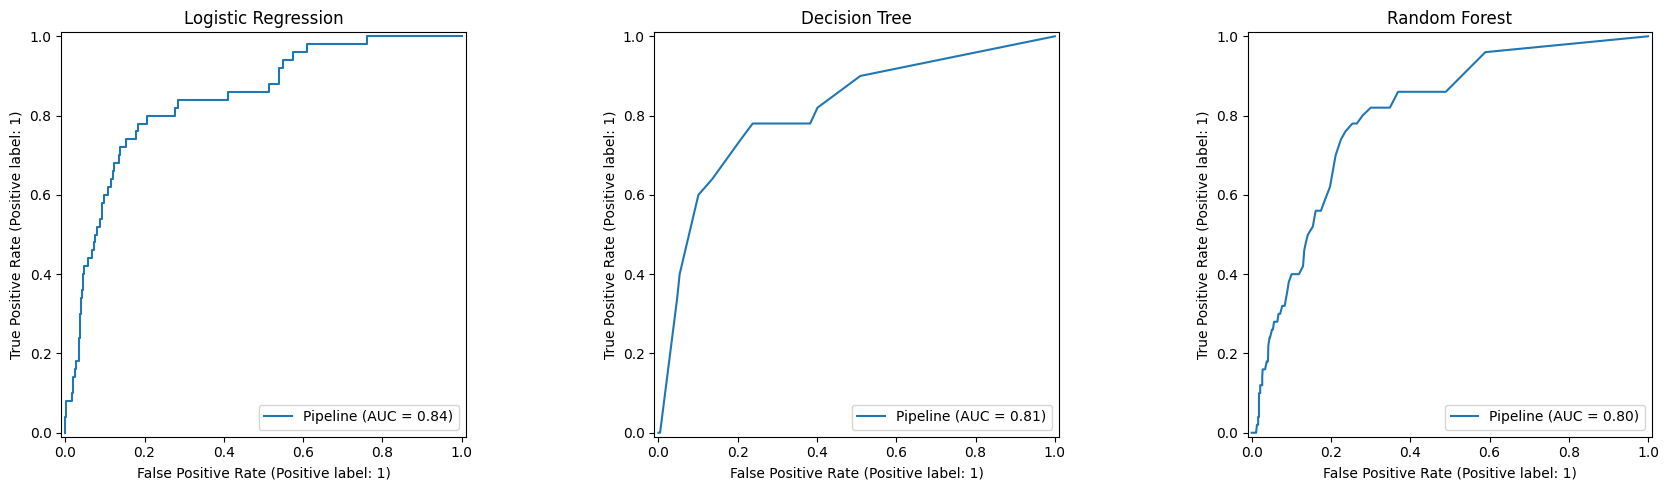

In [26]:
# Create a figure with 3 subplots row
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot Logistic Regression on ax[0]
ax[0].set_title("Logistic Regression")
RocCurveDisplay.from_estimator(log_reg, X_test, y_test, ax=ax[0])

# Plot Decision Tree on ax[1]
ax[1].set_title("Decision Tree")
RocCurveDisplay.from_estimator(dt, X_test, y_test, ax=ax[1])

# Plot Random Forest on ax[2]
ax[2].set_title("Random Forest")
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax[2])

plt.tight_layout()
plt.show()

## Final Insights
- Dataset is highly imbalanced → ROC-AUC is preferred over accuracy
- Logistic Regression gives strong baseline performance
- Random Forest captures non-linear patterns better
- Further gains possible using SMOTE, XGBoost, or threshold tuning

Random Forest is a strong candidate for deployment.